In [ ]:
# Enabling and testing the GPU
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
# Mount the Google Drive to Google Colab
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Import all the required libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping 
from glob import glob
from scipy.io import loadmat
from IPython.display import Image, display
from PIL import ImageOps

In [ ]:
# Specify training data directory
Training_Directory = "./gdrive/My Drive/image_segmentation/Training"

In [ ]:
# Create training image dataset path list
NUM_TRAIN_IMAGES = round(0.9 * len(glob(os.path.join(Training_Directory, "Images/*"))))
train_images = sorted(glob(os.path.join(Training_Directory, "Images/*")))[:NUM_TRAIN_IMAGES]
train_masks = sorted(glob(os.path.join(Training_Directory, 
                                       "Ground_Truth/*")))[:NUM_TRAIN_IMAGES]

print('Number of images for training: {} \n'.format(len(train_images)))

Number of images for training: 1125 



In [ ]:
# Display a sample in training dataset
print('Path of 1st image: {} \n'.format(train_images[0]))
print('Path of 1st mask : {} \n'.format(train_masks[0]))

Path of 1st image: ./gdrive/My Drive/image_segmentation/Training/Images/0001562.jpg 

Path of 1st mask : ./gdrive/My Drive/image_segmentation/Training/Ground_Truth/0001562.png 



In [ ]:
# Create validation image dataset path list
NUM_VAL_IMAGES = len(glob(os.path.join(Training_Directory, "Images/*"))) - NUM_TRAIN_IMAGES
val_images = sorted(glob(os.path.join(Training_Directory, "Images/*")))[
    NUM_TRAIN_IMAGES : NUM_VAL_IMAGES + NUM_TRAIN_IMAGES]
val_masks = sorted(glob(os.path.join(Training_Directory, "Ground_Truth/*")))[
    NUM_TRAIN_IMAGES : NUM_VAL_IMAGES + NUM_TRAIN_IMAGES]

print('Number of images for validation: {} \n'.format(len(val_images)))

print('Total number of images in the dataset: {} \n'.format(NUM_TRAIN_IMAGES+NUM_VAL_IMAGES))

Number of images for validation: 125 

Total number of images in the dataset: 1250 



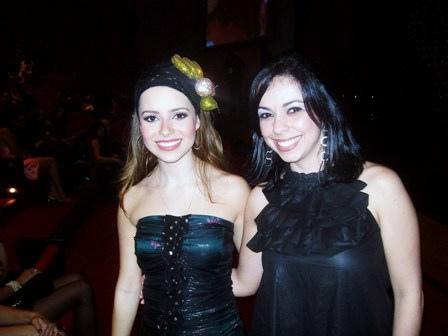

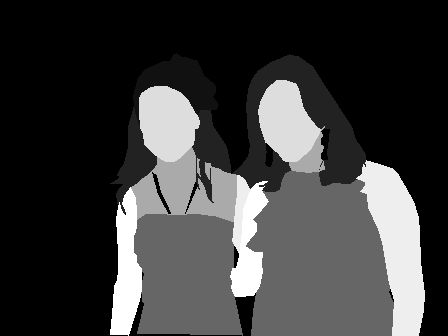

In [ ]:
# Display a sample input image and corresponding segmentation mask
# Display input image
display(Image(filename=train_images[3]))
# Display auto-contrast version of corresponding target
display(ImageOps.autocontrast(load_img(train_masks[3])))

In [ ]:
# Preprocess and prepare batches of images
BATCH_SIZE = 4 #Batch size
IMAGE_SIZE = 512 #Image size to resize

def read_image(image_path, mask=False):
    image = tf.io.read_file(image_path)
    if mask:
        image = tf.image.decode_png(image, channels=1)
        image.set_shape([None, None, 1])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
    else:
        image = tf.image.decode_png(image, channels=3)
        image.set_shape([None, None, 3])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = image / 127.5 - 1
    return image

def load_data(image_list, mask_list):
    image = read_image(image_list)
    mask = read_image(mask_list, mask=True)
    return image, mask

def data_generator(image_list, mask_list):
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset

train_dataset = data_generator(train_images, train_masks)
print('Number of batches in training dataset: {} \n'.format(len(train_dataset)))
val_dataset = data_generator(val_images, val_masks)
print('Number of batches in validation dataset: {} \n'.format(len(val_dataset)))

Number of batches in training dataset: 281 

Number of batches in validation dataset: 31 



In [ ]:
# Build a model
def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    padding="same",
    use_bias=False,
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)

def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output

def DeeplabV3Plus(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    resnet50 = keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=model_input
    )
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    return keras.Model(inputs=model_input, outputs=model_output)

NUM_CLASSES = 20
model = DeeplabV3Plus(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES)
model.summary()

94765736/94765736 [==============================] - 7s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 518, 518, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 256, 256, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                             

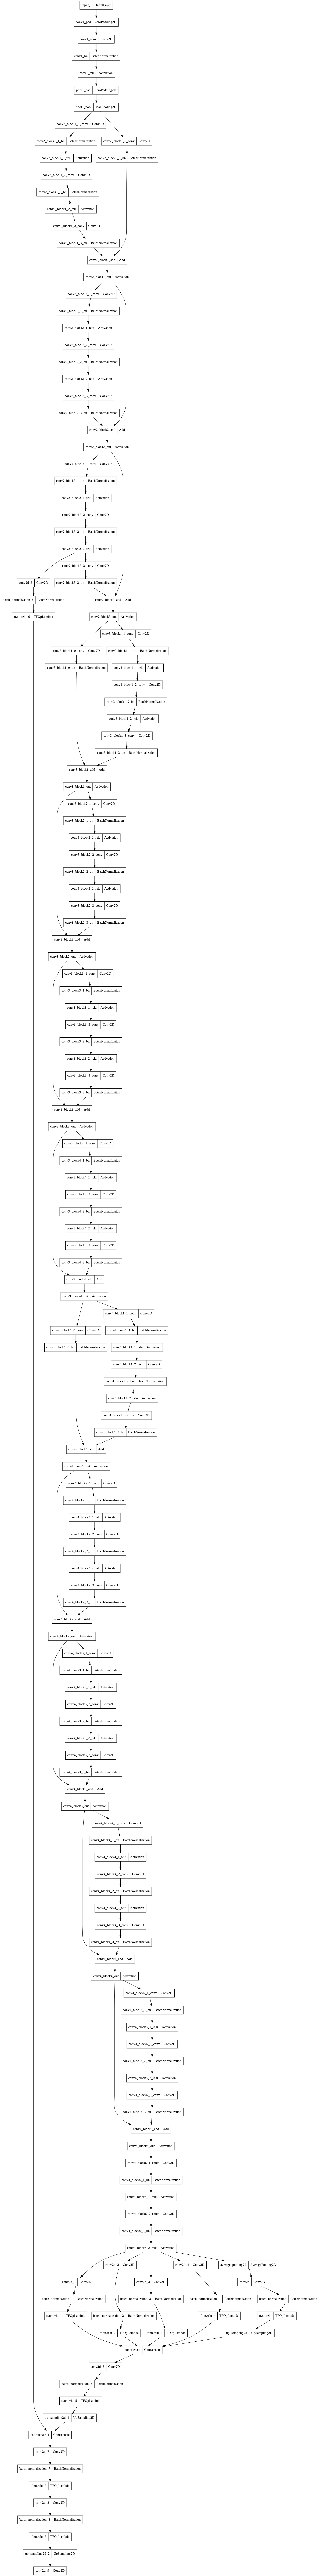

In [ ]:
# Display the model architecture
plot_model(model, to_file='model.png')

In [ ]:
# Compiling Model
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss=loss, metrics=["accuracy"],)

In [ ]:
# using early stopping to exit training 
#if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', 
                              mode='min', 
                              verbose=1, 
                              patience=20)

In [ ]:
# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="./gdrive/My Drive/image_segmentation/segment_weights.h5", 
                               monitor='val_loss',
                               mode='min',
                               verbose=1, 
                               save_best_only=True)

In [ ]:
# Training the model
history = model.fit(train_dataset, validation_data=val_dataset, epochs=25, 
                    callbacks=[checkpointer, earlystopping])

Epoch 1/25
281/281 [==============================] - ETA: 0s - loss: 1.2074 - accuracy: 0.6313
Epoch 1: val_loss improved from inf to 3.51680, saving model to ./gdrive/My Drive/image_segmentation/segment_weights.h5
281/281 [==============================] - 516s 2s/step - loss: 1.2074 - accuracy: 0.6313 - val_loss: 3.5168 - val_accuracy: 0.5802
Epoch 2/25
281/281 [==============================] - ETA: 0s - loss: 0.9342 - accuracy: 0.6989
Epoch 2: val_loss improved from 3.51680 to 2.37940, saving model to ./gdrive/My Drive/image_segmentation/segment_weights.h5
281/281 [==============================] - 123s 436ms/step - loss: 0.9342 - accuracy: 0.6989 - val_loss: 2.3794 - val_accuracy: 0.5885
Epoch 3/25
281/281 [==============================] - ETA: 0s - loss: 0.8270 - accuracy: 0.7310
Epoch 3: val_loss improved from 2.37940 to 1.08212, saving model to ./gdrive/My Drive/image_segmentation/segment_weights.h5
281/281 [==============================] - 121s 429ms/step - loss: 0.8270 - a

In [ ]:
# Loading the pretrained weights
model.load_weights("./gdrive/My Drive/image_segmentation/segment_weights.h5")

In [ ]:
# Specify the directory of images for performing segmentation
Prediction_Directory = './gdrive/My Drive/image_segmentation/Prediction'
# Check the number of images in the directory
prediction_paths = []
for i in os.listdir(Prediction_Directory):
  img = os.path.join(Prediction_Directory, i)
  prediction_paths.append(img)
print('Number of images in the Prediction folder: {} \n'.format(len(prediction_paths)))
prediction_paths.sort()

Number of images in the Prediction folder: 40 



In [ ]:
# Loading the Colormap
colormap = loadmat(
    "./gdrive/My Drive/image_segmentation/human_colormap.mat"
)["colormap"]
colormap = colormap * 100
colormap = colormap.astype(np.uint8)

# Helper functions
def infer(model, image_tensor):
    predictions = model.predict(np.expand_dims((image_tensor), axis=0))
    predictions = np.squeeze(predictions)
    predictions = np.argmax(predictions, axis=2)
    return predictions

def decode_segmentation_masks(mask, colormap, n_classes):
    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)
    for l in range(0, n_classes):
        idx = mask == l
        r[idx] = colormap[l, 0]
        g[idx] = colormap[l, 1]
        b[idx] = colormap[l, 2]
    rgb = np.stack([r, g, b], axis=2)
    return rgb

def get_overlay(image, colored_mask):
    image = tf.keras.preprocessing.image.array_to_img(image)
    image = np.array(image).astype(np.uint8)
    overlay = cv2.addWeighted(image, 0.35, colored_mask, 0.65, 0)
    return overlay

def plot_samples_matplotlib(display_list, figsize=(5, 3)):
    _, axes = plt.subplots(nrows=1, ncols=len(display_list), figsize=figsize)
    for i in range(len(display_list)):
        if display_list[i].shape[-1] == 3:
            axes[i].imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        else:
            axes[i].imshow(display_list[i])
    plt.show()

# Plotting the predicted segmented masks
def plot_predictions(images_list, colormap, model):
    for image_file in images_list:
        image_tensor = read_image(image_file)
        prediction_mask = infer(image_tensor=image_tensor, model=model)
        prediction_colormap = decode_segmentation_masks(prediction_mask, colormap, 20)
        overlay = get_overlay(image_tensor, prediction_colormap)
        plot_samples_matplotlib(
            [image_tensor, overlay, prediction_colormap], figsize=(18, 14)
        )

# Segmentation mask of custom images
plot_predictions(prediction_paths, colormap, model=model)

Output hidden; open in https://colab.research.google.com to view.